In [0]:
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from random import randint

> # **Aula 022** - Redes convolucionais com estimators - **Tensorflow: Redes Neurais Convolucionais**

In [128]:
mnist = input_data.read_data_sets('mnist/', one_hot=False)

x_training = mnist.train.images
y_training = mnist.train.labels
x_test = mnist.test.images
y_test = mnist.test.labels

Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz


In [0]:
y_training = np.asanyarray(y_training, dtype= np.int32)
y_test = np.asanyarray(y_test, dtype= np.int32)

Text(0.5, 1.0, 'Classe: 2')

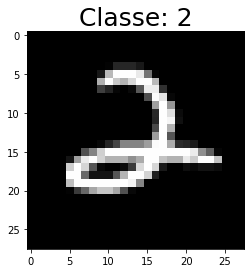

In [130]:
img_index = randint(0, 50000)
plt.imshow(x_training[img_index].reshape(28,28), cmap='gray')
plt.title(f'Classe: {y_training[img_index]}', fontdict={'size':25})

In [0]:
# features = x_training | labels = y_training | variáveis obrigatórias (escritas dessa mesma forma)
def create_network(features, labels, mode):
  # features['X'] = nome em formato de dicionario para poder referenciar as caracteristicas depois.
  # o segundo parametro = [batch_size, altura_img, largura_img, canais] # batch_size = -1 -> variavel | canais = 1 -> imagens em preto e branco
  entrada = tf.reshape(features['X'], [-1, 28, 28, 1])

  # ----- feature maps -----
  # filters = quantidade de mapas de caracteristicas (feature maps)
  # kernel_size = tamanho do detector de caracteristicas (feature detector)
  # activation = funçao de ativação
  # padding = 'same' | preserva a altura e largura da imagem durante as transformações
  # recebe [batch_size, 28, 28, 1] | retorna [batch_size, 28, 28, 32] 32 imagens com diferentes filtros (32 FILTROS NÂO CANAIS)
  convolucao_1 = tf.layers.conv2d(inputs= entrada, filters= 32, kernel_size=[5,5], activation= tf.nn.relu,
                                  padding= 'same')
  
  # ----- max pooling -----
  # pool_size = tamanho do pooling
  # strides = quantidade de pixels incrementados em cada iteração do pooling
  # recebe [batch_size, 28, 28, 32] | retorna [batch_size, 14, 14, 32]
  pooling_1 = tf.layers.max_pooling2d(inputs= convolucao_1, pool_size= [2,2], strides= 2)

  # recebe [batch_size, 14, 14, 32] | retorna [batch_size, 14, 14, 64]
  convolucao_2 = tf.layers.conv2d(inputs= pooling_1, filters= 64, kernel_size= [5,5], activation= tf.nn.relu,
                                  padding= 'same')
  
  # recebe [batch_size, 14, 14, 64] | retorna [batch_size, 7, 7, 64]
  pooling_2 = tf.layers.max_pooling2d(inputs= convolucao_2, pool_size= [2,2], strides= 2)

  # ----- flatterning -----
  # entrada = [batch_size, 7, 7, 64] | retorna [batch_size, 3136]
  flatteining = tf.reshape(pooling_2, [-1, 7*7*64])

  # ----- dense neural network -----77
  # entrada -> 3136
  # camada oculta -> uma com 1024 neuronios
  # saida -> 10 neuronios (probabilidade para cada uma das dez classes)
  densa = tf.layers.dense(inputs= flatteining, units= 1024, activation= tf.nn.relu)
  # dropout (zera uma parte das entradas para evitar overfitting)
  dropout = tf.layers.dropout(inputs= densa, rate= 0.2, training= mode == tf.estimator.ModeKeys.TRAIN)

  # ----- output -----
  # recebe [batch_size, 1024]
  # retorna [batch_size, 10]
  output = tf.layers.dense(inputs= dropout, units= 10)
  previsoes = tf.argmax(output, axis= 1)

  if(mode == tf.estimator.ModeKeys.PREDICT):
    return tf.estimator.EstimatorSpec(mode= mode, predictions= previsoes)

  # one_hot = True -> tf.nn.softmax_cross_entropy_with_logits_v2
  # one_hot = False -> tf.losses.sparse_softmax_cross_entropy | melhor para grandes quantidades de classes 
  erro = tf.losses.sparse_softmax_cross_entropy(labels= labels, logits= output)



  if(mode == tf.estimator.ModeKeys.TRAIN):
    otimizador = tf.train.AdamOptimizer(learning_rate= 0.001)
    treinamento = otimizador.minimize(erro, global_step= tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode= mode, loss= erro, train_op = treinamento)
  
  if(mode == tf.estimator.ModeKeys.EVAL):
    eval_metric = {'accurary': tf.metrics.accuracy(labels= labels, predictions= previsoes)}
    return tf.estimator.EstimatorSpec(mode= mode, loss= erro, eval_metric_ops= eval_metric)

In [132]:
classificator = tf.estimator.Estimator(model_fn= create_network)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpygcsno7g', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff329d9d8d0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [133]:
training_function = tf.estimator.inputs.numpy_input_fn(x= {'X': x_training}, y= y_training,
                                                       batch_size = 128, num_epochs= None, shuffle= True)

classificator.train(input_fn= training_function, steps= 200)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpygcsno7g/model.ckpt.
INFO:tensorflow:loss = 2.3172708, step = 1
INFO:tensorflow:global_step/sec: 2.70654
INFO:tensorflow:loss = 0.13478446, step = 101 (36.949 sec)
INFO:tensorflow:Saving checkpoints for 200 into /tmp/tmpygcsno7g/model.ckpt.
INFO:tensorflow:Loss for final step: 0.06325874.


In [134]:
# tests
test_function = tf.estimator.inputs.numpy_input_fn(x= {'X': x_test}, y= y_test, num_epochs= 1, shuffle= False)
results = classificator.evaluate(input_fn= test_function)
results

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-02-19T20:35:19Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpygcsno7g/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2020-02-19-20:35:26
INFO:tensorflow:Saving dict for global step 200: accurary = 0.9791, global_step = 200, loss = 0.061276715
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 200: /tmp/tmpygcsno7g/model.ckpt-200


{'accurary': 0.9791, 'global_step': 200, 'loss': 0.061276715}

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpygcsno7g/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


Text(0.5, 1.0, 'Classe prevista: 4')

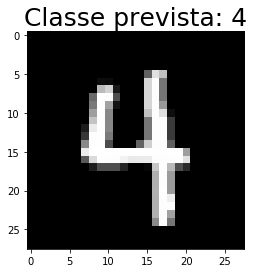

In [153]:
# predicts
x_img_test = x_test[randint(0, x_test.shape[0])]
x_img_test = x_img_test.reshape(1,-1)

predict_function = tf.estimator.inputs.numpy_input_fn(x= {'X': x_img_test}, shuffle= False)
predict = list(classificator.predict(input_fn= predict_function))

plt.imshow(x_img_test.reshape(28,28), cmap='gray')
plt.title(f'Classe prevista: {predict[0]}', fontdict={'fontsize':25})